## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Load area of experiment (AGEB and blocks)

In [2]:
chosen_ageb = '0515'

Load AGEB

In [3]:
pop_schema = 'censoageb'
pop_table = 'censoageb_2020'
ent = '01'

query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE \"cve_ent\" LIKE \'{ent}\'"
ags_pop_ageb = aup.gdf_from_query(query, geometry_col='geometry')
ags_pop_ageb = ags_pop_ageb.set_crs("EPSG:4326")

chosen_ageb_gdf = ags_pop_ageb.loc[ags_pop_ageb.cve_ageb == chosen_ageb]

# Show
print(f"AGEB elegido con población de {chosen_ageb_gdf.pobtot.unique()}.")
chosen_ageb_gdf

AGEB elegido con población de [2585].


,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,geometry,entidad,nom_ent,mun,nom_mun,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
239,0100100010515,01,001,0001,0515,"POLYGON ((-102.29278 21.89010, -102.29275 21.8...",1,Aguascalientes,1,Aguascalientes,...,759.0,621.0,454.0,325.0,124.0,19.0,24.0,204.0,NaN,0100100010515


Load blocks

In [4]:
pop_schema = 'censo_mza'
pop_table = 'censo_mza_2020'
ent = '01'

query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE \"CVE_ENT\" LIKE \'{ent}\'"
ags_pop_mza = aup.gdf_from_query(query, geometry_col='geometry')
ags_pop_mza = ags_pop_mza.set_crs("EPSG:4326")

mza_gdf = ags_pop_mza.loc[ags_pop_mza.CVE_AGEB == chosen_ageb]

# Show
print(mza_gdf.shape)
mza_gdf.head(1)

(48, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
2034,0100100010515001,01,001,0001,0515,001,Urbana,Típica,"POLYGON ((-102.29552 21.88697, -102.29516 21.8...",1,...,35,49,41,27,18,3,None,None,14,0


<Axes: >

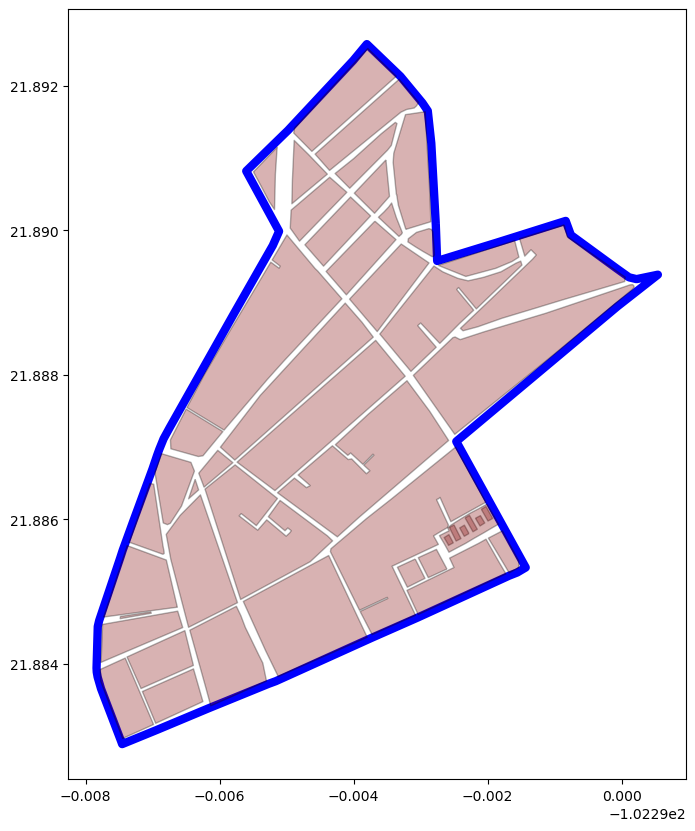

In [5]:
# Show
fig, ax = plt.subplots(figsize=(10, 10))
mza_gdf.plot(ax=ax, color="maroon", alpha=0.3, edgecolor="black",zorder=1)
chosen_ageb_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=6,zorder=0)

## Methodology

### Filter data for columns of interest

In [114]:
columns_of_interest = ['POBTOT','POBFEM','POBMAS',
                       'P_0A2','P_0A2_F','P_0A2_M',
                       'P_3A5','P_3A5_F','P_3A5_M',
                       'P_6A11','P_6A11_F','P_6A11_M',
                       'P_12A14','P_12A14_F','P_12A14_M',
                       'P_15A17','P_15A17_F','P_15A17_M',
                       'P_18A24','P_18A24_F','P_18A24_M',
                       'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                       'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                       'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                       'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                       'P_18YMAS','P_18YMAS_F','P_18YMAS_M']

# Filter for blocks
mza_gdf_f = mza_gdf[columns_of_interest+['CVEGEO','geometry']]

# Filter for ageb
ageb_columns_of_interest = [x.lower() for x in columns_of_interest]
chosen_ageb_gdf_f = chosen_ageb_gdf[ageb_columns_of_interest+['geometry']]

### tests - age_YMAS

#### [P_0A2 = POBTOT - P_3YMAS] ? -----> SUCCESS

In [60]:
test_gdf = mza_gdf_f.copy()

test_gdf['P_3YMAS'] = pd.to_numeric(test_gdf['P_3YMAS'])
test_gdf['P_0A2'] = pd.to_numeric(test_gdf['P_0A2'])

test_gdf['test'] = test_gdf['POBTOT'] - test_gdf['P_3YMAS']

test_gdf = test_gdf[['POBTOT','P_3YMAS','test','P_0A2']]

test_gdf['diff'] = test_gdf['P_0A2'] - test_gdf['test']

print(f' Difference: {test_gdf["diff"].sum()}')
test_gdf

 Difference: 0.0


,POBTOT,P_3YMAS,test,P_0A2,diff
2034,179,173.0,6.0,6.0,0.0
2035,176,172.0,4.0,4.0,0.0
2036,81,77.0,4.0,4.0,0.0
2037,145,144.0,1.0,NaN,NaN
2038,97,96.0,1.0,NaN,NaN
2039,180,176.0,4.0,4.0,0.0
2040,88,85.0,3.0,3.0,0.0
2041,15,14.0,1.0,NaN,NaN
2042,139,131.0,8.0,8.0,0.0
2043,65,62.0,3.0,3.0,0.0


SyntaxError: f-string: unmatched '[' (3449421262.py, line 12)

### Calculate nan values experiment

In [143]:
test_gdf = mza_gdf_f.copy()

##########################################################################################
# STEP 1: KEEP OUT OF THE PROCESS ROWS WHICH HAVE 0 VALUES (ALL NaNS)

# a) Set columns to be analysed (Remove POBTOT because it is always published)
analysis_cols = columns_of_interest.copy()
analysis_cols.remove('POBTOT')

# b) Set found values to 0
test_gdf['found_values'] = 0

# c) Find rows with nan values and sum nan values  
for col in analysis_cols:
    # Turn to numeric
    test_gdf[col] = pd.to_numeric(test_gdf[col])

    # Set checker column to 'exist' (1)
    test_gdf[f'check_{col}'] = 1
    
    # If it doesn't exist, set that row's check to (0)
    idx = test_gdf[col].isna()
    test_gdf.loc[idx, f'check_{col}'] = 0

    # Sum total row nan values
    test_gdf['found_values'] = test_gdf['found_values'] + test_gdf[f'check_{col}']

    test_gdf.drop(columns=[f'check_{col}'],inplace=True)

# d) Loc and drop rows with 0 values (useless)
blocks_values = test_gdf.loc[test_gdf['found_values'] > 0].copy()
blocks_values.drop(columns=['found_values'],inplace=True)

# e) Save rows with 0 values for later.
blocks_nans = test_gdf.loc[test_gdf['found_values'] == 0].copy()
blocks_nans.drop(columns=['found_values'],inplace=True)

##########################################################################################
# STEP 2: Calculate nan values experiment

# a) Count current (original) nan values
original_nan_values = int(blocks_values.isna().sum().sum())

# b) Set a start and finish nan value for while loop
start_nan_values = original_nan_values
finish_nan_values = start_nan_values - 1

# c) Run calculating loop
i = 1
while start_nan_values > finish_nan_values:

    # ROUND STARTING DATA
    start_nan_values = blocks_values.isna().sum().sum()

    ######################################################################################
    # PARENT - SUB EQUATIONS
    
    # POBTOT = POBFEM + POBMAS
    blocks_values.POBTOT.fillna(blocks_values.POBFEM + blocks_values.POBMAS, inplace=True)
    blocks_values.POBFEM.fillna(blocks_values.POBTOT - blocks_values.POBMAS, inplace=True)
    blocks_values.POBMAS.fillna(blocks_values.POBTOT - blocks_values.POBFEM, inplace=True)
    
    # P_0A2 = P_0A2_F + P_0A2_M
    blocks_values.P_0A2.fillna(blocks_values.P_0A2_F + blocks_values.P_0A2_M, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.P_0A2 - blocks_values.P_0A2_M, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.P_0A2 - blocks_values.P_0A2_F, inplace=True)
    
    # P_3A5 = P_3A5_F + P_3A5_M
    blocks_values.P_3A5.fillna(blocks_values.P_3A5_F + blocks_values.P_3A5_M, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.P_3A5 - blocks_values.P_3A5_M, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.P_3A5 - blocks_values.P_3A5_F, inplace=True)
    
    # P_6A11 = P_6A11_F + P_6A11_M
    blocks_values.P_6A11.fillna(blocks_values.P_6A11_F + blocks_values.P_6A11_M, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.P_6A11 - blocks_values.P_6A11_M, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.P_6A11 - blocks_values.P_6A11_F, inplace=True)
    
    # P_12A14 = P_12A14_F + P_12A14_M
    blocks_values.P_12A14.fillna(blocks_values.P_12A14_F + blocks_values.P_12A14_M, inplace=True)
    blocks_values.P_12A14_F.fillna(blocks_values.P_12A14 - blocks_values.P_12A14_M, inplace=True)
    blocks_values.P_12A14_M.fillna(blocks_values.P_12A14 - blocks_values.P_12A14_F, inplace=True)
    
    # P_15A17 = P_15A17_F + P_15A17_M
    blocks_values.P_15A17.fillna(blocks_values.P_15A17_F + blocks_values.P_15A17_M, inplace=True)
    blocks_values.P_15A17_F.fillna(blocks_values.P_15A17 - blocks_values.P_15A17_M, inplace=True)
    blocks_values.P_15A17_M.fillna(blocks_values.P_15A17 - blocks_values.P_15A17_F, inplace=True)
    
    # P_18A24 = P_18A24_F + P_18A24_M
    blocks_values.P_18A24.fillna(blocks_values.P_18A24_F + blocks_values.P_18A24_M, inplace=True)
    blocks_values.P_18A24_F.fillna(blocks_values.P_18A24 - blocks_values.P_18A24_M, inplace=True)
    blocks_values.P_18A24_M.fillna(blocks_values.P_18A24 - blocks_values.P_18A24_F, inplace=True)
    
    # P_60YMAS = P_60YMAS_F + P_60YMAS_M
    blocks_values.P_60YMAS.fillna(blocks_values.P_60YMAS_F + blocks_values.P_60YMAS_M, inplace=True)
    blocks_values.P_60YMAS_F.fillna(blocks_values.P_60YMAS - blocks_values.P_60YMAS_M, inplace=True)
    blocks_values.P_60YMAS_M.fillna(blocks_values.P_60YMAS - blocks_values.P_60YMAS_F, inplace=True)
    
    ######################################################################################
    # "{AGE}_YMAS" EQUATIONS
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_3YMAS = P_0A2
    # --> P_0A2 = POBTOT - P_3YMAS
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_3YMAS, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_3YMAS_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_3YMAS_M, inplace=True)

    # --> P_3YMAS = POBTOT - P_0A2
    blocks_values.P_3YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2, inplace=True)
    blocks_values.P_3YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F, inplace=True)
    blocks_values.P_3YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M, inplace=True)
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_12YMAS = (P_0A2 + P_3A5 + P_6A11)
    # --> P_0A2 = POBTOT - P_12YMAS - P_3A5 - P_6A11
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)
    
    # --> P_3A5 = POBTOT - P_12YMAS - P_0A2 - P_6A11
    blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_0A2 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M, inplace=True)
    
    # --> P_6A11 = POBTOT - P_12YMAS - P_0A2 - P_3A5
    blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_0A2 - blocks_values.P_3A5, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M, inplace=True)
    
    # --> P_12YMAS = POBTOT - P_0A2 - P_3A5 -P_6A11
    blocks_values.P_12YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_12YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_12YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)    
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_15YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14)
    # --> P_0A2 = POBTOT - P_15YMAS - P_3A5 - P_6A11 - P_12A14
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
    
    # --> P_3A5 = POBTOT - P_15YMAS - P_0A2 - P_6A11 - P_12A14
    blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
    
    # --> P_6A11 = POBTOT - P_15YMAS - P_0A2 - P_3A5 - P_12A14
    blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_12A14_M, inplace=True)
    
    # --> P_12A14 = POBTOT - P_15YMAS - P_0A2 - P_3A5 - P_6A11
    blocks_values.P_12A14.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_12A14_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_12A14_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)

    # --> P_15YMAS = POBTOT - P_0A2 - P_3A5 - P_6A11 - P_12A14
    blocks_values.P_15YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_15YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_15YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_18YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14 + P_15A17)
    # --> P_0A2 = POBTOT - P_18YMAS - P_3A5 - P_6A11 - P_12A14 - P_15A17
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_3A5 = POBTOT - P_18YMAS - P_0A2 - P_6A11 - P_12A14 - P_15A17
    blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_6A11 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_12A14 - P_15A17
    blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_12A14 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_6A11 - P_15A17
    blocks_values.P_12A14.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_12A14_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_12A14_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_15A17 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_6A11 - P_12A14
    blocks_values.P_15A17.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_15A17_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_15A17_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)

    # --> P_18YMAS = POBTOT - P_0A2 - P_3A5 - P_6A11 - P_12A14 - P_15A17
    blocks_values.P_18YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_18YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_18YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)

    ######################################################################################
    # COMPLEMENTARY ECUATIONS (WIP)

    # H/M Relation

    #POBTOT = POB0_14 + POB15_64 + POB65YMAS

    #POB0_14 = P_0A2 + P_3A5 + P_6A11 + P_12A14

    #P_15YMAS = POBTOT - POB0_14

    # ROUND FINISHING DATA
    finish_nan_values = blocks_values.isna().sum().sum()
    print(f'Round {i} Starting with {start_nan_values} nan values. Finishing with {finish_nan_values} nan values.')

    i = i+1

# Show
print(f'Originally gdf had {original_nan_values} nan values, now there are {finish_nan_values}. A {round(((1-(finish_nan_values/original_nan_values))*100),2)}% reduction.')
blocks_values.head(1)

Round 1 Starting with 262 nan values. Finishing with 75 nan values.
Round 2 Starting with 75 nan values. Finishing with 47 nan values.
Round 3 Starting with 47 nan values. Finishing with 47 nan values.
Originally gdf had 262 nan values, now there are 47. A 82.06% reduction.


,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_12YMAS_F,P_12YMAS_M,P_15YMAS,P_15YMAS_F,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,CVEGEO,geometry
2034,179,117.0,62.0,6.0,4.0,2.0,9.0,7.0,2.0,9.0,...,99.0,56.0,148.0,95.0,53.0,142.0,92.0,50.0,0100100010515001,"POLYGON ((-102.29552 21.88697, -102.29516 21.8..."


## WIP

In [145]:
blocks_all = pd.concat([blocks_values,blocks_nans])

######################################################################################
# AGEB filling
for col in analysis_cols:
    # Find number of nan values in col
    col_nan_values = blocks_all.isna().sum()[col]

    # If there are no nan values left, pass.
    if col_nan_values == 0:
        analysis_cols.remove(col) # Stop analysing that column in further while loops.
        print(f'Col {col} fully solved.')
        pass
    
    # Elif there are more than one nan (unsolvable), pass.
    elif col_nan_values > 1:
        print(f'Col {col} unsolvable for now (WIP).')
        pass
        
    # Elif there is only one value left, we can find it using AGEB data and stop analysing that column in further while loops.
    elif col_nan_values == 1: 
        # Calculate missing value
        ageb_col_value = chosen_ageb_gdf[col.lower()].unique()[0]
        current_block_sum = blocks_all[col].sum()
        missing_value = ageb_col_value - current_block_sum

        # Add missing value to na spot in column
        blocks_all[col].fillna(missing_value,inplace=True)

        analysis_cols.remove(col) # Stop analysing that column in further while loops.

        print(f'Filled col {col} with AGEB values.')

Col POBFEM unsolvable for now (WIP).
Col POBMAS unsolvable for now (WIP).
Col P_0A2 unsolvable for now (WIP).
Col P_0A2_F unsolvable for now (WIP).
Col P_0A2_M unsolvable for now (WIP).
Col P_3A5 unsolvable for now (WIP).
Col P_3A5_F unsolvable for now (WIP).
Col P_3A5_M unsolvable for now (WIP).
Col P_6A11 unsolvable for now (WIP).
Col P_6A11_F unsolvable for now (WIP).
Col P_6A11_M unsolvable for now (WIP).
Col P_12A14 unsolvable for now (WIP).
Col P_12A14_F unsolvable for now (WIP).
Col P_12A14_M unsolvable for now (WIP).
Col P_15A17 unsolvable for now (WIP).
Col P_15A17_F unsolvable for now (WIP).
Col P_15A17_M unsolvable for now (WIP).
Col P_18A24 unsolvable for now (WIP).
Col P_18A24_F unsolvable for now (WIP).
Col P_18A24_M unsolvable for now (WIP).
Col P_60YMAS unsolvable for now (WIP).
Col P_60YMAS_F unsolvable for now (WIP).
Col P_60YMAS_M unsolvable for now (WIP).
Col P_3YMAS unsolvable for now (WIP).
Col P_3YMAS_F unsolvable for now (WIP).
Col P_3YMAS_M unsolvable for now (

# Tests

In [136]:
test = blocks_values.loc[blocks_values['P_12YMAS_F'].isna()].copy()
test = test.drop(columns=['POBTOT', 'POBFEM', 'POBMAS', 
                          'P_0A2', 'P_0A2_F', 'P_0A2_M', 
                          'P_3A5', 'P_3A5_F', 'P_3A5_M', 
                          'P_6A11','P_6A11_F', 	'P_6A11_M', 	
                          'P_12A14', 'P_12A14_F', 'P_12A14_M', 	
                          'P_15A17', 'P_15A17_F', 'P_15A17_M',	
                          'P_18A24', 'P_18A24_F'])
test

,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_12YMAS,P_12YMAS_F,P_12YMAS_M,P_15YMAS,P_15YMAS_F,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,CVEGEO,geometry
2041,0.0,0.0,0.0,0.0,14.0,7.0,7.0,9.0,NaN,7.0,8.0,NaN,6.0,8.0,NaN,6.0,0100100010515008,"POLYGON ((-102.29630 21.88666, -102.29628 21.8..."
2052,0.0,5.0,0.0,5.0,18.0,8.0,17.0,18.0,NaN,17.0,18.0,NaN,17.0,18.0,NaN,17.0,0100100010515020,"POLYGON ((-102.29607 21.88344, -102.29613 21.8..."


In [138]:
blocks_values.isna().sum()

POBTOT        0
POBFEM        0
POBMAS        0
P_0A2         0
P_0A2_F       0
P_0A2_M       0
P_3A5         5
P_3A5_F       2
P_3A5_M       4
P_6A11        5
P_6A11_F      2
P_6A11_M      4
P_12A14       0
P_12A14_F     0
P_12A14_M     0
P_15A17       0
P_15A17_F     0
P_15A17_M     0
P_18A24       3
P_18A24_F     5
P_18A24_M     5
P_60YMAS      0
P_60YMAS_F    2
P_60YMAS_M    2
P_3YMAS       0
P_3YMAS_F     0
P_3YMAS_M     0
P_12YMAS      0
P_12YMAS_F    0
P_12YMAS_M    0
P_15YMAS      0
P_15YMAS_F    0
P_15YMAS_M    0
P_18YMAS      0
P_18YMAS_F    0
P_18YMAS_M    0
CVEGEO        0
geometry      0
dtype: int64

In [126]:
def fill_values(row):

    parent_col = parent_column
    sub_col_1 = sub_columns[0]
    sub_col_2 = sub_columns[1]
    
    # Case 1: parent col missing
    if (row[f'tmp_{parent_col}'] == 0) and (row[f'tmp_{sub_col_1}'] == 1) and (row[f'tmp_{sub_col_2}'] == 1):
        print(f'Filling parent col {parent_column} for block {row["CVEGEO"]} with values {row[sub_col_1]} + {row[sub_col_2]}')
        
        row[parent_col] = row[sub_col_1] + row[sub_col_2]
        return row

    # Case 2: First sub_col missing
    elif (row[f'tmp_{parent_col}'] == 1) and (row[f'tmp_{sub_col_1}'] == 0) and (row[f'tmp_{sub_col_2}'] == 1):
        print(f'Filling first sub_col {sub_col_1} for block {row["CVEGEO"]} with values {row[parent_col]} - {row[sub_col_2]}')
        
        row[sub_col_1] = row[parent_col] - row[sub_col_2]
        return row

    # Case 2: Second sub_col missing
    elif (row[f'tmp_{parent_col}'] == 1) and (row[f'tmp_{sub_col_1}'] == 1) and (row[f'tmp_{sub_col_2}'] == 0):
        print(f'Filling second sub_col {sub_col_2} for block {row["CVEGEO"]} with values {row[parent_col]} - {row[sub_col_1]}')
        
        row[sub_col_2] = row[parent_col] - row[sub_col_1]
        return row

    else:
        return row

In [128]:
test_gdf = mza_gdf_f.copy()

columns_dicc= {'POBTOT':['POBFEM','POBMAS'],
               'P_0A2':['P_0A2_F','P_0A2_M'],
               'P_3A5':['P_3A5_F','P_3A5_M'],
               'P_6A11':['P_6A11_F','P_6A11_M'],
               'P_12A14':['P_12A14_F','P_12A14_M'],
               'P_15A17':['P_15A17_F','P_15A17_M'],
               'P_18A24':['P_18A24_F','P_18A24_M'],
               'P_60YMAS':['P_60YMAS_F','P_60YMAS_M']}
               
               
for parent_column in columns_dicc.keys():
    
    # Set sub columns
    sub_columns = columns_dicc[parent_column]

    # Convert columns to numeric and identify nan values in cells
    analysis_cols = [parent_column] + sub_columns
    
    for col in analysis_cols:
        # Turn to numeric
        test_gdf[col] = pd.to_numeric(test_gdf[col])
    
        # Identify nan values
        test_gdf[f'tmp_{col}'] = 1
        idx = test_gdf[col].isna()
        test_gdf.loc[idx, f'tmp_{col}'] = 0
    
    # Fill values
    i = 0
    test_gdf = test_gdf.apply(lambda row: fill_values(row),axis='columns')
    
    for col in analysis_cols:    
        test_gdf.drop(columns=[f'tmp_{col}'],inplace=True)

test_gdf

Filling first sub_col POBFEM for block 0100100010515020 with values 18 - 17.0
Filling first sub_col P_0A2_F for block 0100100010515024 with values 5.0 - 3.0
Filling second sub_col P_0A2_M for block 0100100010515001 with values 6.0 - 4.0
Filling first sub_col P_0A2_F for block 0100100010515002 with values 4.0 - 3.0
Filling first sub_col P_0A2_F for block 0100100010515006 with values 4.0 - 3.0
Filling first sub_col P_3A5_F for block 0100100010515019 with values 4.0 - 3.0
Filling first sub_col P_3A5_F for block 0100100010515024 with values 5.0 - 3.0
Filling second sub_col P_3A5_M for block 0100100010515001 with values 9.0 - 7.0
Filling first sub_col P_6A11_F for block 0100100010515009 with values 7.0 - 6.0
Filling first sub_col P_6A11_F for block 0100100010515013 with values 6.0 - 4.0
Filling first sub_col P_6A11_F for block 0100100010515019 with values 6.0 - 4.0
Filling second sub_col P_6A11_M for block 0100100010515001 with values 9.0 - 7.0
Filling second sub_col P_12A14_M for block 010

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,CVEGEO,geometry
2048,139,64.0,75.0,8.0,3.0,5.0,6.0,0.0,6.0,7.0,...,4.0,1.0,6.0,1.0,5.0,31.0,17.0,14.0,0100100010515009,"POLYGON ((-102.29454 21.88944, -102.29454 21.8..."
2049,65,33.0,32.0,3.0,NaN,NaN,NaN,0.0,NaN,3.0,...,NaN,NaN,8.0,2.0,6.0,16.0,8.0,8.0,0100100010515011,"POLYGON ((-102.29492 21.89030, -102.29436 21.8..."
2050,57,32.0,25.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,0.0,7.0,4.0,3.0,15.0,8.0,7.0,0100100010515012,"POLYGON ((-102.29432 21.89020, -102.29405 21.8..."
2051,69,33.0,36.0,NaN,NaN,NaN,NaN,0.0,NaN,6.0,...,NaN,NaN,6.0,1.0,5.0,16.0,12.0,4.0,0100100010515013,"POLYGON ((-102.29368 21.89013, -102.29354 21.8..."
2052,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0100100010515014,"POLYGON ((-102.29305 21.88998, -102.29297 21.8..."
2053,45,23.0,22.0,0.0,0.0,0.0,NaN,0.0,NaN,4.0,...,0.0,0.0,3.0,NaN,NaN,11.0,7.0,4.0,0100100010515015,"POLYGON ((-102.29253 21.88958, -102.29248 21.8..."
2054,161,95.0,66.0,4.0,4.0,0.0,NaN,NaN,NaN,13.0,...,0.0,NaN,10.0,4.0,6.0,48.0,28.0,20.0,0100100010515016,"POLYGON ((-102.29086 21.89008, -102.29081 21.8..."
2055,217,118.0,99.0,3.0,0.0,3.0,12.0,5.0,7.0,10.0,...,5.0,3.0,18.0,11.0,7.0,54.0,34.0,20.0,0100100010515017,"POLYGON ((-102.29363 21.88614, -102.29359 21.8..."
2056,30,18.0,12.0,0.0,0.0,0.0,NaN,NaN,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,11.0,8.0,3.0,0100100010515018,"POLYGON ((-102.29261 21.88531, -102.29289 21.8..."
2057,105,61.0,44.0,NaN,NaN,NaN,4.0,1.0,3.0,6.0,...,NaN,0.0,10.0,6.0,4.0,31.0,21.0,10.0,0100100010515019,"POLYGON ((-102.29486 21.88525, -102.29475 21.8..."


In [125]:
mza_gdf_f.loc[mza_gdf_f.CVEGEO == '0100100010515001']

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,CVEGEO,geometry
2126,179,117,62,6,4,None,9,7,None,9,...,3,3,20,16,4,47,31,16,0100100010515001,"POLYGON ((-102.29552 21.88697, -102.29516 21.8..."


In [124]:
test_gdf.loc[test_gdf.CVEGEO == '0100100010515001']

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,CVEGEO,geometry
2126,179,117.0,62.0,6.0,4.0,2.0,9.0,7.0,2.0,9.0,...,3.0,3.0,20.0,16.0,4.0,47.0,31.0,16.0,0100100010515001,"POLYGON ((-102.29552 21.88697, -102.29516 21.8..."
